# Intersections

## Setup

In [38]:
from amftrack.util.sys import storage_path
from amftrack.util.image_analysis import convert_to_micrometer
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np

In [25]:
source = os.path.join(storage_path, "BAS_WIDTH", "20220614_Plate1058_width")

def is_valid(name):
    return ".json" in name

segments = {}
for file in os.listdir(source):
    if is_valid(file):
        path = os.path.join(source, file)
        with open(path) as f:
            json_from_file = json.load(f)
        segments[file] = {"main1": [], "main2": [], "son1": []}
        for shape in json_from_file["shapes"]:
            if shape["label"] in segments[file].keys():
                segments[file][shape["label"]].append(shape["points"])

In [26]:
segments['Image001.json']['main1']

[[[2010.9090909090908, 749.090909090909],
  [2008.4848484848483, 852.121212121212]],
 [[2316.0655737704915, 757.7049180327868],
  [2307.5409836065573, 863.6065573770491]],
 [[4027.631578947368, 893.4210526315788],
  [4021.929824561403, 997.8070175438595]]]

In [27]:
widths = {}

for key in segments.keys():
    widths[key] = {}
    for label in segments[key].keys():
        lengths = []
        for i in range(len(segments[key][label])):
            point1 = np.array(segments[key][label][i][0])
            point2 = np.array(segments[key][label][i][1])
            length = convert_to_micrometer(
                        np.linalg.norm(point1 - point2), magnification=50
                    )
            lengths.append(length)
        widths[key][label] = np.mean(lengths)

## I/ Plots

In [32]:
main1 = [widths[key]['main1'] for key in widths.keys()]
main2 = [widths[key]['main2'] for key in widths.keys()]
son1 = [widths[key]['son1'] for key in widths.keys()]
x = list(range(len(widths.keys())))

<IPython.core.display.Javascript object>


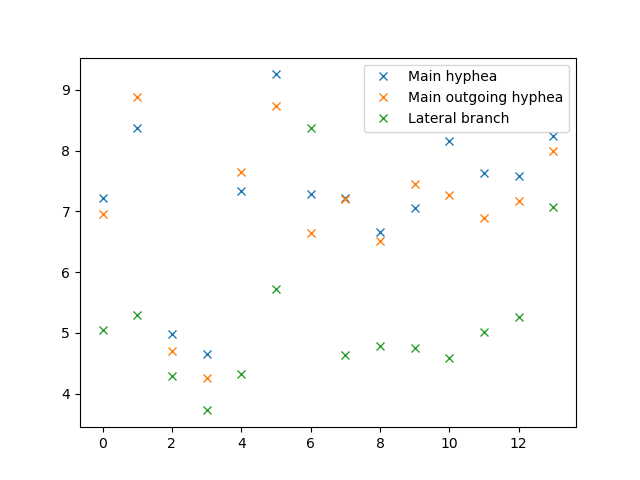

In [36]:
%matplotlib notebook
plt.plot(x, main1, marker = 'x', linestyle = "None", label = "Main hyphea")
plt.plot(x, main2, marker = 'x', linestyle = "None", label = "Main outgoing hyphea")
plt.plot(x, son1, marker = 'x', linestyle = "None", label = "Lateral branch")
plt.legend()

## 2/ Tests statistiques

**Q1**: A-t-on main1 > main2 ?\
**Q2**: Si oui, quelle est la relation la mieux vérifiée du type $main_1^{a} = main_2^{a} + son_1^{a}$?

## Q1

$H_0$: There is no reduction at intersection\
$H_1$: There is a reduction at intersection

$X1$ = valeurs de la branche d'entrée\
$X2$ = valeurs de la branche de sortie\
$X = X1 - X2$\
$H_0$: $X$ suit une loi normale de moyenne 0 et d'écart type inconnu.\
$H_1$: $X$ suit une loi normale de moyenne supérieur à 0 et d'écart type inconnu\

In [33]:
X = np.array(main1) - np.array(main2)
S = np.var(X, ddof=0)

In [35]:
S

0.16250369481741614

In [34]:
np.mean(X)

0.23893626636453963

In [36]:
(np.mean(X)/S) * np.sqrt(13)

5.301399213803841

$\overline{X}/S*racine(n-1)$ suit une loi de student

In [24]:
from scipy.stats import t, ttest_1samp

In [42]:
ttest_1samp(X, popmean=0)

Ttest_1sampResult(statistic=2.137086639831958, pvalue=0.05217128299188655)

In [39]:
help(ttest_1samp)

Help on function ttest_1samp in module scipy.stats._stats_py:

ttest_1samp(a, popmean, axis=0, nan_policy='propagate', alternative='two-sided')
    Calculate the T-test for the mean of ONE group of scores.
    
    This is a test for the null hypothesis that the expected value
    (mean) of a sample of independent observations `a` is equal to the given
    population mean, `popmean`.
    
    Parameters
    ----------
    a : array_like
        Sample observation.
    popmean : float or array_like
        Expected value in null hypothesis. If array_like, then it must have the
        same shape as `a` excluding the axis dimension.
    axis : int or None, optional
        Axis along which to compute test; default is 0. If None, compute over
        the whole array `a`.
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan.
        The following options are available (default is 'propagate'):
    
          * 'propagate': returns 

2.16 = 0.05


## 3/ Solving murray's law

Example

### Solving for one point

In [77]:
r1 = main1[6]
r2 = main2[6]
r3 = son1[6]

In [78]:
print(f"{r1}, {r2}; {r3}")

7.283784637791719, 6.635404189007974; 8.37218778012714


In [ ]:
r1 = 1
r2 = 1
r3 = 0.6

In [60]:
def F(alpha):
    return r1**alpha - r2**alpha - r3**alpha

x = scipy.optimize.broyden1(F, [0.2], f_tol=1e-11)
x

array([4.9835868])

Better to be a very low value for convergence in our case.

### Solving for all points

In [61]:
def F(alpha, r1, r2, r3):
    return r1**alpha - r2**alpha - r3**alpha

In [62]:
def F_(alpha, frac1, frac2):
    return 1 - frac1**alpha - frac2**alpha

In [79]:
l = []
for i in range(len(main1)):
    r1 = main1[i]
    r2 = main2[i]
    r3 = son1[i]
    frac1 = r2/r1
    frac2 = r3/r1
    if r2 < r1 and r3 < r1:
        f = lambda alpha: F_(alpha, frac1, frac2)
        try:
            alpha = scipy.optimize.broyden1(f, [0.2], f_tol=1e-11)
        except:
            alpha = None
        l.append(alpha)
    else:
        l.append(np.inf)

In [80]:
l

[array([4.9835868]),
 inf,
 array([7.20083168]),
 array([4.7236823]),
 inf,
 array([3.53447723]),
 inf,
 array([8.94777437]),
 array([6.22895839]),
 inf,
 array([2.45302018]),
 array([3.09652764]),
 array([4.20720167]),
 array([9.34395601])]